## Import libraries

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Replace 'path_to_your_dataset.csv' with the actual file path
dataset_path = '/content/drive/My Drive/cicids2017.csv'
df = pd.read_csv(dataset_path)

# Display the first few rows
df.head()


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# print the class distribution of the last column
df['Label'].value_counts()

,count
Label,
BENIGN,22731
DoS,19035
PortScan,7946
BruteForce,2767
WebAttack,2180
Bot,1966
Infiltration,36


### Data pre-processing

In [ ]:
# Encode the dataset
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])


In [ ]:
# address empty values
if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace = True)

In [ ]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Machine learning model training

### Training six base learners (for comparison purposes):
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

Training time:  1.483123540878296
Prediction time per sample:  0.00037932810374836966
Cross-Validation scores:  [0.99490404 0.99291813 0.9935138 ]
Mean of Cross-Validation scores:  0.9937786550171627
Accuracy of DT: 0.9955881055325156
Precision of DT: 0.9955619442695871
Recall of DT: 0.9955881055325156
F1-score of DT: 0.9955567987296643
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.99      1.00      0.99       436

    accuracy                           1.00     11333
   macro avg       0.96      0.93      0.95     11333
weighted avg       1.00      1.00      1.00     11333



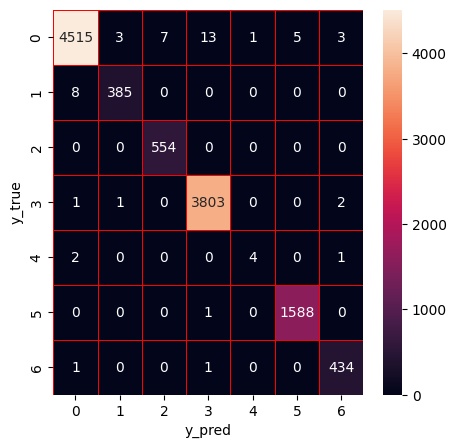

CPU times: user 5.05 s, sys: 125 ms, total: 5.17 s
Wall time: 5.29 s


In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### RF

Training time:  11.394744396209717
Prediction time:  0.009335771427879915 ms
Cross-Validation scores:  [0.99364659 0.99371236 0.99404329]
Mean of Cross-Validation scores:  0.9938007446645121
Accuracy of RF: 0.9951469160857672
Precision of RF: 0.9951376956404765
Recall of RF: 0.9951469160857672
F1-score of RF: 0.9951233485431371
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



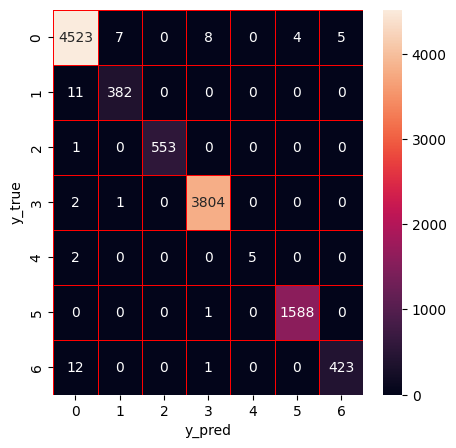

CPU times: user 32.1 s, sys: 165 ms, total: 32.3 s
Wall time: 32.5 s


In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### ET

Training time:  4.278567552566528
Prediction time:  0.013600651273068521 ms
Cross-Validation scores:  [0.98808736 0.98768946 0.98828513]
Mean of Cross-Validation scores:  0.9880206480164281
Accuracy of ET: 0.9894996911673872
Precision of ET: 0.9895868550132068
Recall of ET: 0.9894996911673872
F1-score of ET: 0.9894399241016295
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4547
           1       0.93      0.97      0.95       393
           2       0.98      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.43      0.60         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.96      0.97       436

    accuracy                           0.99     11333
   macro avg       0.98      0.91      0.93     11333
weighted avg       0.99      0.99      0.99     11333



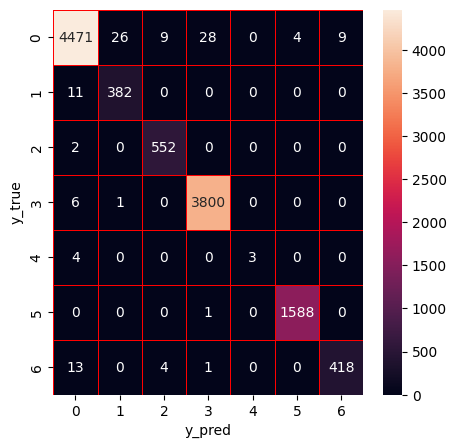

CPU times: user 15.4 s, sys: 174 ms, total: 15.6 s
Wall time: 15.5 s


In [ ]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0)
et_scores = cross_val_score(et, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
et.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(X_test) * 1000, 'ms')


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  12.176076650619507
Prediction time per sample:  0.012826385201838139
Cross-Validation scores:  [0.99702184 0.99702164 0.99616123]
Mean of Cross-Validation scores:  0.9967349036591912
Accuracy of XGBoost: 0.9978822906556075
Precision of XGBoost: 0.9978822836231637
Recall of XGBoost: 0.9978822906556075
F1-score of XGBoost: 0.997865327936054
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



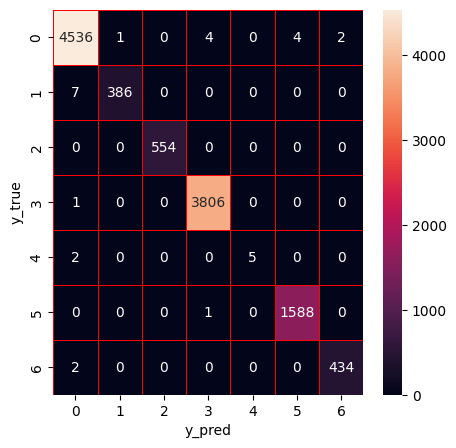

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0)
xg_scores = cross_val_score(xg, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13317
[LightGBM] [Info] Number of data points in the train set: 30218, number of used features: 65
[LightGBM] [Info] Start training from score -0.913333
[LightGBM] [Info] Start training from score -3.360600
[LightGBM] [Info] Start training from score -3.019780
[LightGBM] [Info] Start training from score -1.090767
[LightGBM] [Info] Start training from score -7.371754
[LightGBM] [Info] Start training from score -1.964346
[LightGBM] [Info] Start training from score -3.258295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

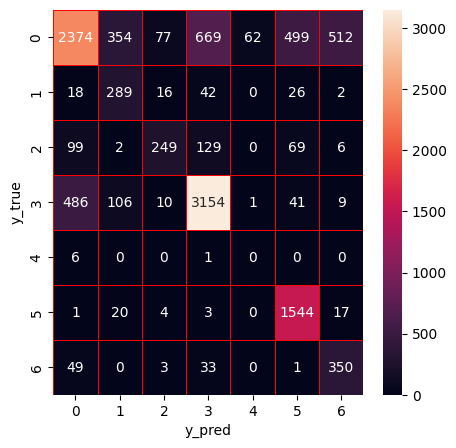

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=3)

# calculate the training time
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### Catboost

Training time:  182.8832061290741
Prediction time per sample:  0.028799630574659164
Cross-Validation scores:  [0.99662475 0.99688927 0.99695546]
Mean of Cross-Validation scores:  0.9968231600425393
Accuracy of CatBoost: 0.9972646254301597
Precision of CatBoost: 0.9972667325353783
Recall of CatBoost: 0.9972646254301597
F1-score of CatBoost: 0.9972288336160174
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.57      0.73         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.94      0.96     11333
weighted avg       1.00      1.00      1.00     11333



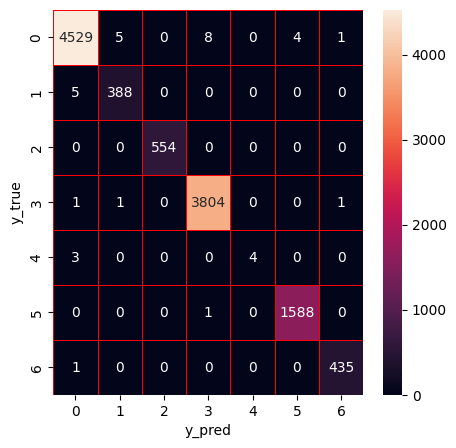

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False)
cat_scores = cross_val_score(cat, X_train, y_train, cv=3)


# calculate the training time
start = time.time()
cat.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
# record the results
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)
dt_prob_train=dt.predict_proba(X_train)
dt_prob_test=dt.predict_proba(X_test)

rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)
rf_prob_train=rf.predict_proba(X_train)
rf_prob_test=rf.predict_proba(X_test)

et_train=et.predict(X_train)
et_test=et.predict(X_test)
et_prob_train=et.predict_proba(X_train)
et_prob_test=et.predict_proba(X_test)

xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)
xg_prob_train=xg.predict_proba(X_train)
xg_prob_test=xg.predict_proba(X_test)

lgbm_train=lgbm.predict(X_train)
lgbm_test=lgbm.predict(X_test)
lgbm_prob_train=lgbm.predict_proba(X_train)
lgbm_prob_test=lgbm.predict_proba(X_test)

cat_train=cat.predict(X_train)
cat_test=cat.predict(X_test)
cat_prob_train=cat.predict_proba(X_train)
cat_prob_test=cat.predict_proba(X_test)


## Model selection

In [ ]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [ ]:
top_3_models

['cat', 'xg', 'rf']

## Model Ensemble

In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Training time of Stacking: 1.9163968563079834
Testing time of Stacking: 0.005463220893700314
Accuracy of Stacking: 0.995235153975117
Precision of Stacking: 0.9952358376103508
Recall of Stacking: 0.995235153975117
F1-score of Stacking: 0.9952115333107117
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



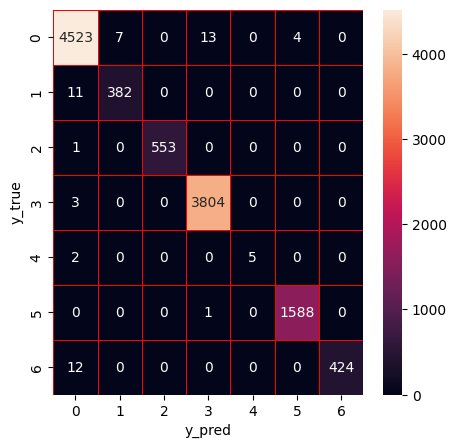

In [ ]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_test = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 4.871326684951782
Testing time of Stacking: 0.0026139579361622997
Accuracy of Stacking: 0.9953233918644666
Precision of Stacking: 0.9952870835703269
Recall of Stacking: 0.9953233918644666
F1-score of Stacking: 0.9952811785929738
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      0.99      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       0.97      0.93      0.94     11333
weighted avg       1.00      1.00      1.00     11333



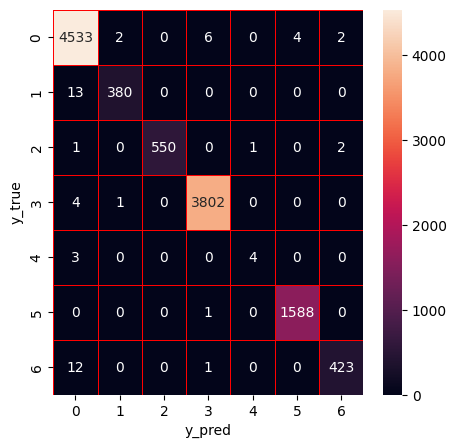

In [ ]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 2.4346420764923096
Testing time of Stacking: 0.0027372590296163065
Accuracy of Stacking: 0.9961175328686138
Precision of Stacking: 0.9960833569084533
Recall of Stacking: 0.9961175328686138
F1-score of Stacking: 0.9960798704555729
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       0.99      0.97      0.98       393
           2       1.00      0.99      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.93      0.95     11333
weighted avg       1.00      1.00      1.00     11333



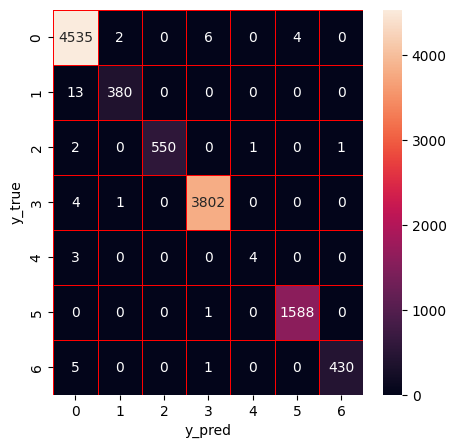

In [ ]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_test)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_test)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [ ]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [ ]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [ ]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.099, 'Bwd Packet Length Min'), (0.0854, 'Bwd Packet Length Std'), (0.0569, 'Init_Win_bytes_forward'), (0.0513, 'Average Packet Size'), (0.0508, 'Init_Win_bytes_backward'), (0.0404, 'PSH Flag Count'), (0.0378, 'Bwd Packets/s'), (0.0309, 'Fwd PSH Flags'), (0.0293, 'Avg Bwd Segment Size'), (0.0271, 'Bwd Header Length'), (0.0259, 'Fwd Header Length'), (0.0248, 'Packet Length Mean'), (0.0245, 'Packet Length Std'), (0.0206, 'Packet Length Variance'), (0.0185, 'min_seg_size_forward'), (0.0183, 'Bwd Packet Length Mean'), (0.0174, 'Fwd Header Length.1'), (0.0156, 'Flow Bytes/s'), (0.0147, 'Bwd Packet Length Max'), (0.0146, 'Max Packet Length'), (0.0145, 'Flow IAT Min'), (0.0143, 'Total Length of Fwd Packets'), (0.0141, 'Fwd Packet Length Mean'), (0.0139, 'Total Length of Bwd Packets'), (0.0133, 'Fwd Packet Length Max'), (0.0127, 'Fwd IAT Min'), (0.0127, 'Avg Fwd Segment Size'), (0.0106, 'Total Fwd Packets'), (0.0101, 'Subflow Bwd Bytes'), (0.01, 'Subflow Fwd 

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [ ]:
# regenerate the training and test sets with the selected features

X_fs = df[fs].values
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(45328, 39)

In [ ]:
# save the dataset with the selected features
df_fs = pd.DataFrame(X_fs, columns=fs)
df_fs['Label'] = y
df_fs.to_csv('/content/drive/My Drive/cicids2017.csv', index=False)

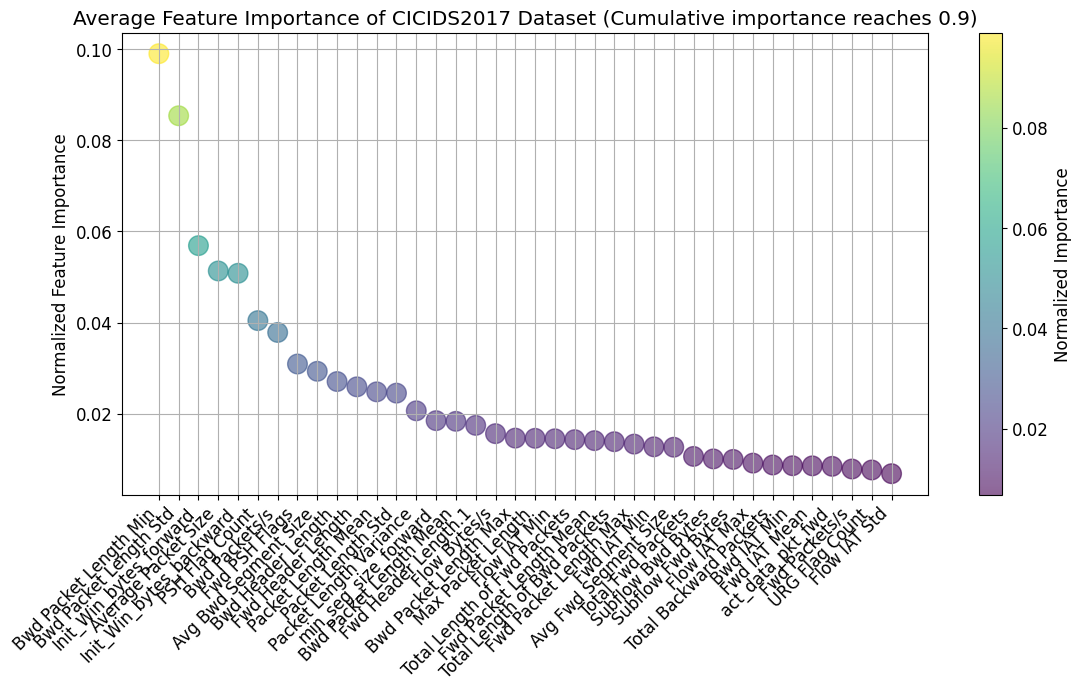

In [ ]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': df.drop(['Label'],axis=1).columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

### Data Balancing by Proposed TVAE-based Method

In [ ]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.3/152.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
pd.Series(y_train).value_counts()

,count
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,29


In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_csv(filepath='/content/drive/My Drive/cicids2017.csv')


In [ ]:
training_set, test_set = train_test_split(df, test_size = 0.2, random_state = 0,stratify = df['Label'])
X_train = training_set[fs]
y_train = training_set.iloc[:, -1]
X_test = test_set[fs]
y_test = test_set.iloc[:, -1]

In [ ]:
training_set['Label'].value_counts()

,count
Label,
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,29


In [ ]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [ ]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))

    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata)

    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training

    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)

    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)


In [ ]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    18184
3    15228
2     6475
6     6475
1     6475
4     6475
5     6357
Name: count, dtype: int64


## Machine learning model training

### Training six base learners:
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

### DT

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time:  0.5500822067260742


ValueError: X has 39 features, but DecisionTreeClassifier is expecting 24 features as input.

100%|██████████| 20/20 [01:00<00:00,  3.05s/trial, best loss: -0.9760315809941938]
Decision Tree: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 10}
Accuracy of DT: 0.9931174446307245
Precision of DT: 0.993158839378575
Recall of DT: 0.9931174446307245
F1-score of DT: 0.9931225010125343
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.97      0.99      0.98       393
           2       0.98      0.99      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.86      0.86      0.86         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.99      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.97      0.97     11333
weighted avg       0.99      0.99      0.99     11333



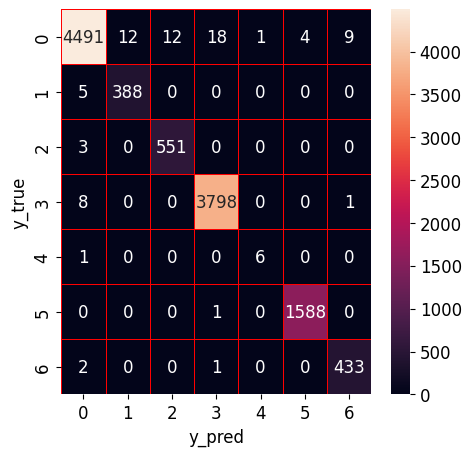

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_test)
y_true = y_test

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### RF

Training time:  18.20022463798523
Prediction time:  0.010792832293367801 ms
Cross-Validation scores:  [0.93115578 0.9978529  0.99780712]
Mean of Cross-Validation scores:  0.9756052658309384
Accuracy of RF: 0.9965587223153622
Precision of RF: 0.9965582147377773
Recall of RF: 0.9965587223153622
F1-score of RF: 0.9965413154700178
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.98      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



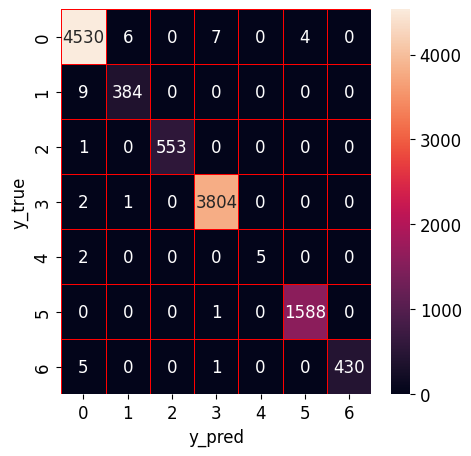

CPU times: user 53.9 s, sys: 155 ms, total: 54 s
Wall time: 54.2 s


In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [34:04<00:00, 102.25s/trial, best loss: -0.9783614585775373]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 18, 'max_features': 34, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 197}
Accuracy of RF: 0.9962940086473132
Precision of RF: 0.9962669637520851
Recall of RF: 0.9962940086473132
F1-score of RF: 0.9962765371167607
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.67      0.57      0.62         7
           5       1.00      1.00      1.00      1589
           6       0.99      1.00      0.99       436

    accuracy                           1.00     11333
   macro avg       0.95      0.93      0.94     11333
weighted avg       1.00      1.00      1.00     11333



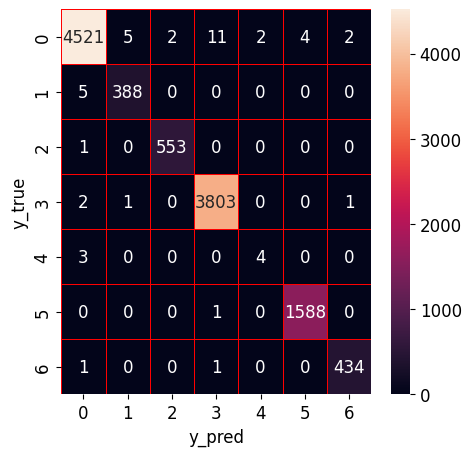

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_test)
y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### ET

Training time:  5.414988279342651
Prediction time:  0.01527176923220843 ms
Cross-Validation scores:  [0.92754683 0.99588853 0.99629951]
Mean of Cross-Validation scores:  0.973244956593744
Accuracy of ET: 0.9929409688520251
Precision of ET: 0.9929678736803398
Recall of ET: 0.9929409688520251
F1-score of ET: 0.9929442180721506
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.95      0.97      0.96       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       0.99      0.99      0.99     11333



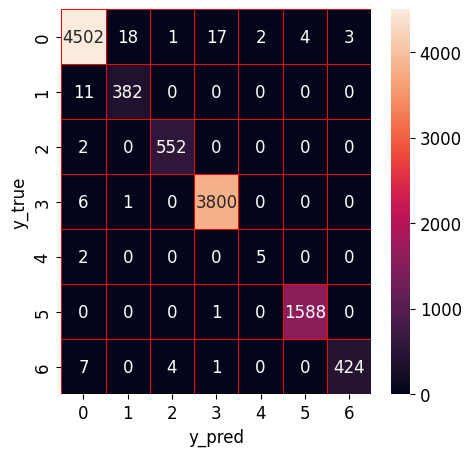

CPU times: user 18.7 s, sys: 129 ms, total: 18.8 s
Wall time: 18.7 s


In [ ]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(X_test) * 1000, 'ms')


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [04:21<00:00, 13.06s/trial, best loss: -0.96992531353929]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 37, 'max_features': 18, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 186}
Accuracy of ET: 0.9935586340774729
Precision of ET: 0.9935730817561133
Recall of ET: 0.9935586340774729
F1-score of ET: 0.9935219413923858
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.97       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.57      0.73         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.99      0.93      0.95     11333
weighted avg       0.99      0.99      0.99     11333



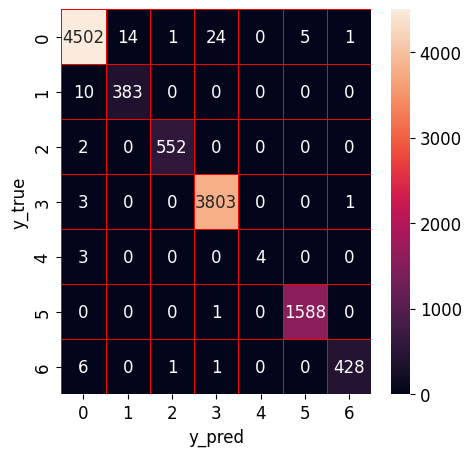

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = et.predict(X_test)
y_true = y_test

# Evaluation metrics
et_score = et.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### XGBoost

Training time:  7.426170825958252
Prediction time per sample:  0.014355752134243178
Cross-Validation scores:  [0.93782549 0.99803563 0.99821828]
Mean of Cross-Validation scores:  0.9780264689855818
Accuracy of XGBoost: 0.9977058148769081
Precision of XGBoost: 0.9977031498718676
Recall of XGBoost: 0.9977058148769081
F1-score of XGBoost: 0.9976887713197095
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



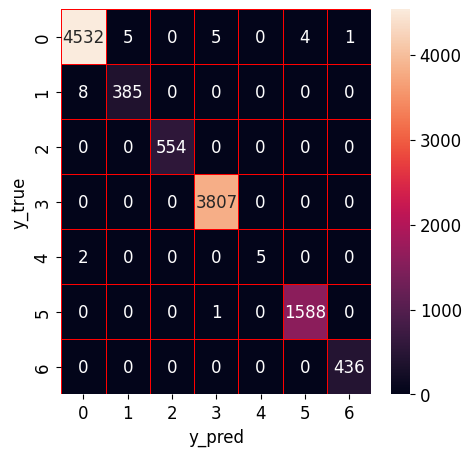

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 20/20 [02:16<00:00,  6.84s/trial, best loss: -0.9972646254301597]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.2136573319972323, 'max_depth': 38, 'n_estimators': 85}
Accuracy of XGBoost: 0.9972646254301597
Precision of XGBoost: 0.9972483714919249
Recall of XGBoost: 0.9972646254301597
F1-score of XGBoost: 0.9972512024792468
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



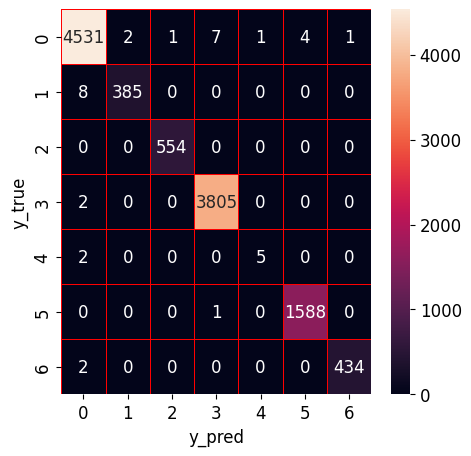

In [ ]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_test)
y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8733
[LightGBM] [Info] Number of data points in the train set: 43779, number of used features: 39
[LightGBM] [Info] Start training from score -1.284050
[LightGBM] [Info] Start training from score -2.316825
[LightGBM] [Info] Start training from score -2.316825
[LightGBM] [Info] Start training from score -1.461484
[LightGBM] [Info] Start training from score -2.316594
[LightGBM] [Info] Start training from score -2.335063
[LightGBM] [Info] Start training from score -2.316594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

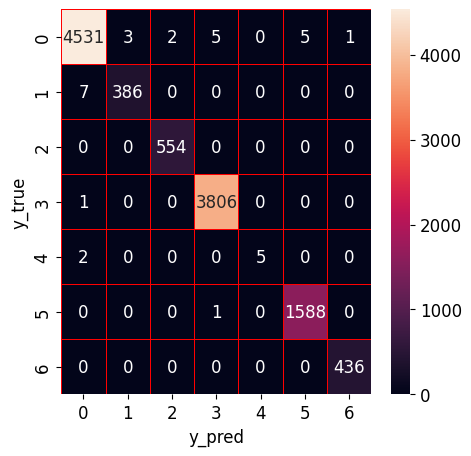

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8743
[LightGBM] [Info] Number of data points in the train set: 65669, number of used features: 39
[LightGBM] [Info] Start training from score -1.284085
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -1.461491
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.335070
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Warning] No further spli

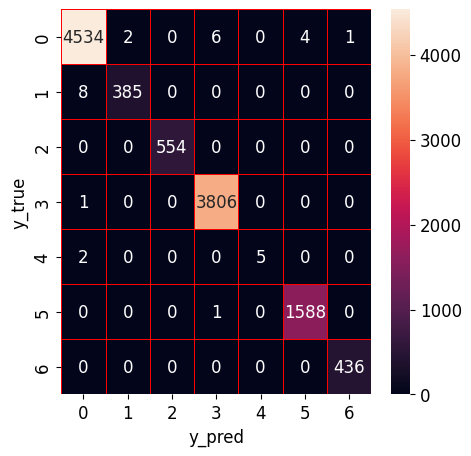

In [ ]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_test)
y_true = y_test

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### CatBoost

Training time:  160.75856828689575
Prediction time per sample:  0.006073898959010484
Cross-Validation scores:  [0.93883052 0.99826405 0.99808123]
Mean of Cross-Validation scores:  0.9783919305806
Accuracy of CatBoost: 0.9973528633195095
Precision of CatBoost: 0.9973528410935183
Recall of CatBoost: 0.9973528633195095
F1-score of CatBoost: 0.9973368882594745
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



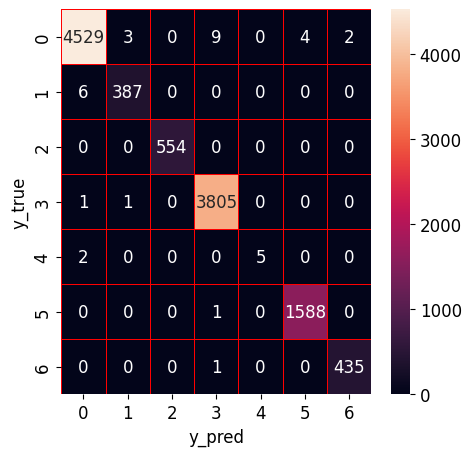

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|██████████| 2/2 [08:56<00:00, 268.15s/trial, best loss: -0.9972646254301597]
CatBoost: Hyperopt estimated optimum {'depth': 8, 'iterations': 900, 'learning_rate': 0.09361960009262599}
Accuracy of CatBoost: 0.9972646254301597
Precision of CatBoost: 0.9972655418219324
Recall of CatBoost: 0.9972646254301597
F1-score of CatBoost: 0.997228091982841
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.57      0.73         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.94      0.96     11333
weighted avg       1.00      1.00      1.00     11333



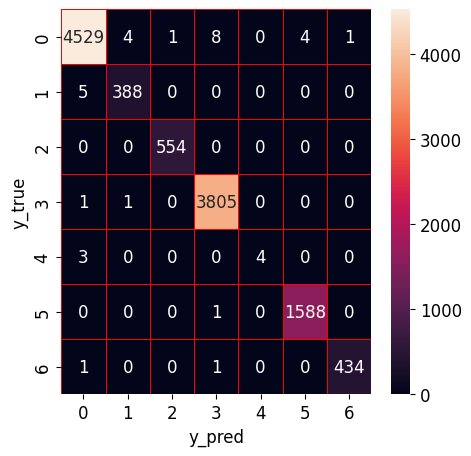

In [ ]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=2)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_test)
y_true = y_test

# Evaluation metrics
cat_score = cat.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_test=dt.predict(X_test)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_test=dt.predict_proba(X_test)

rf_train=rf.predict(X_train_balanced)
rf_test=rf.predict(X_test)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_test=rf.predict_proba(X_test)

et_train=et.predict(X_train_balanced)
et_test=et.predict(X_test)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_test=et.predict_proba(X_test)

xg_train=xg.predict(X_train_balanced)
xg_test=xg.predict(X_test)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_test=xg.predict_proba(X_test)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_test=lgbm.predict(X_test)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_test=lgbm.predict_proba(X_test)

cat_train=cat.predict(X_train_balanced)
cat_test=cat.predict(X_test)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_test=cat.predict_proba(X_test)


## Model selection

In [ ]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [ ]:
top_3_models

['lgbm', 'cat', 'xg']

In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21
[LightGBM] [Info] Number of data points in the train set: 65669, number of used features: 3
[LightGBM] [Info] Start training from score -1.284085
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -1.461491
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.335070
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

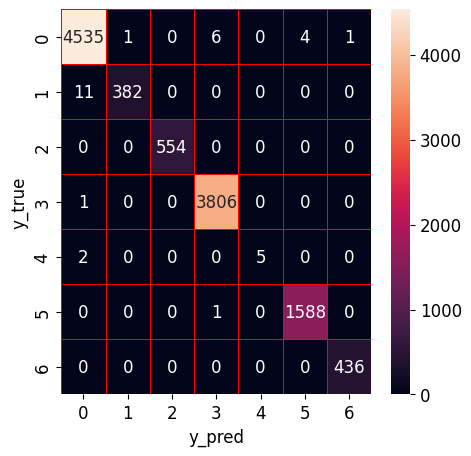

In [ ]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
X_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_test = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5353
[LightGBM] [Info] Number of data points in the train set: 65669, number of used features: 21
[LightGBM] [Info] Start training from score -1.284085
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -1.461491
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.335070
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

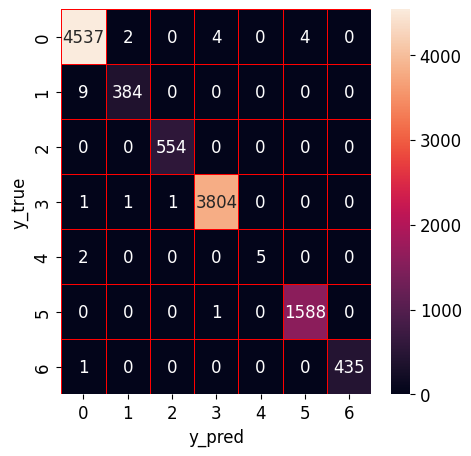

In [ ]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
X_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5374
[LightGBM] [Info] Number of data points in the train set: 65669, number of used features: 24
[LightGBM] [Info] Start training from score -1.284085
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -1.461491
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Info] Start training from score -2.335070
[LightGBM] [Info] Start training from score -2.316678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

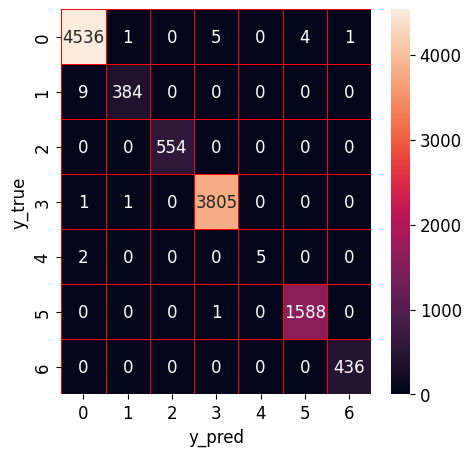

In [ ]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
X_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_test = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps